<a href="https://colab.research.google.com/github/nghiaphan177/CS232.K21/blob/master/Keras_CNN_Dog_or_Cat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Thêm drive vào colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Thư Viện 

In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import zipfile
print(os.listdir("/content/drive/My Drive/dog-cat"))


Using TensorFlow backend.


['test1.zip', 'train.zip', 'sampleSubmission.csv']


# Định nghĩa Constants

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Chuẩn bị Traning Data

In [ ]:
local_zip = '/content/drive/My Drive/dog-cat/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(".")
zip_ref.close()

In [ ]:
filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,cat.10910.jpg,0
1,cat.2682.jpg,0
2,dog.4850.jpg,1
3,dog.3390.jpg,1
4,cat.5221.jpg,0


In [ ]:
df.tail()

,filename,category
24995,cat.5589.jpg,0
24996,dog.10631.jpg,1
24997,dog.8935.jpg,1
24998,dog.10893.jpg,1
24999,dog.6660.jpg,1


### Xem tổng số 

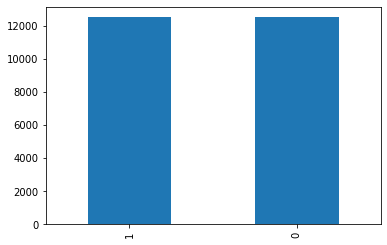

In [ ]:
df['category'].value_counts().plot.bar()

Data chúng ta có 12500 cats và 12500 dogs

# Xem ảnh mẫu 






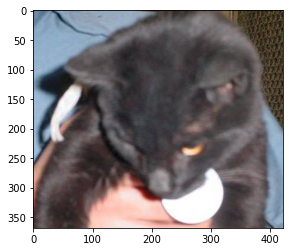

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)

# Xây dựng Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: Nó đại diện cho dữ liệu đầu vào. Nó sẽ định hình lại hình ảnh thành mảng 1 chiều duy nhất. Ví dự như hình ảnh đầu vào là 64x64 = 4096, nó sẽ chuyển đổi thành mảng (4096,1) .
* **Conv Layer**: Lớp này sẽ trích xuất các features từ hình ảnh.
* **Pooling Layer**: Lớp này giảm thể tích hình ảnh đầu vào sau khi tích chập.
* **Fully Connected Layer**: Nó kết nối mạng từ lớp này sang lớp khác
* **Output Layer**: Đây là lớp giá trị dữ đoán. 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 bởi vì chúng ta có 2 lớp dog and cat

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

# Callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

Để ngăn chặn over fitting chúng ta sẽ dừng learning nếu sau 10 epochs và val_loss value không giảm.

In [ ]:
earlystop = EarlyStopping(patience=10)

**Giảm Learning Rate**

Chúng ta sẽ giảm learning rate nếu accuracy không tăng trong 2 steps.

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

# Chuẩn bị data

Bởi vì sẽ sử dụng trình tạo hình ảnh với class_mode = "phân loại". Chúng ta cần chuyển đổi thể loại cột thành chuỗi. Sau đó, imagerenator sẽ chuyển đổi nó one-hot encoding, tốt cho việc phân loại.

Vì vậy, chúng ta sẽ chuyển đổi 1 thành chó và 0 thành mèo

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

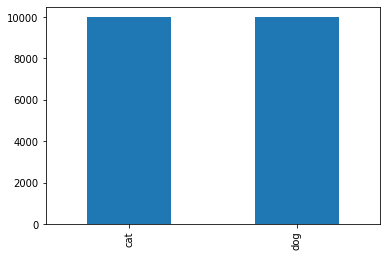

In [ ]:
train_df['category'].value_counts().plot.bar()

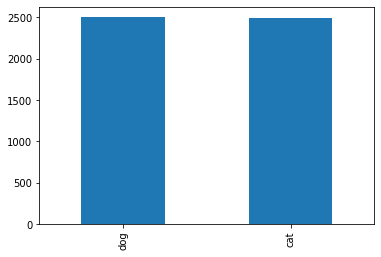

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# Generator làm việc như thế nào

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


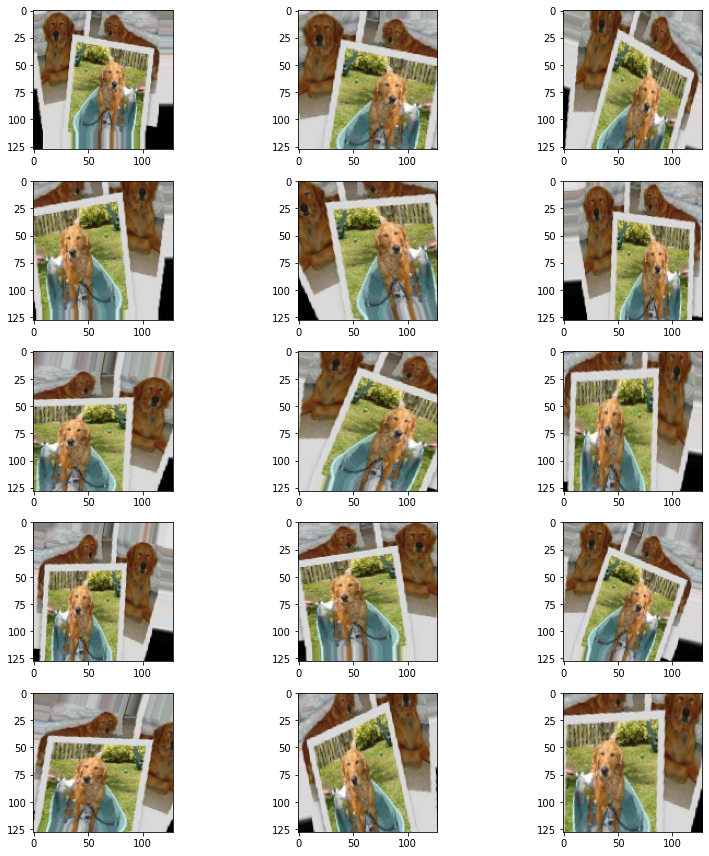

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 192s 144ms/step - loss: 0.7302 - accuracy: 0.6418 - val_loss: 0.7862 - val_accuracy: 0.6969
Epoch 2/50
   1/1333 [..............................] - ETA: 1:43 - loss: 0.7521 - accuracy: 0.6667

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 190s 142ms/step - loss: 0.5575 - accuracy: 0.7235 - val_loss: 0.4076 - val_accuracy: 0.7621
Epoch 3/50
1333/1333 [==============================] - 190s 143ms/step - loss: 0.5035 - accuracy: 0.7583 - val_loss: 0.3663 - val_accuracy: 0.7900
Epoch 4/50
1333/1333 [==============================] - 189s 142ms/step - loss: 0.4758 - accuracy: 0.7804 - val_loss: 0.2892 - val_accuracy: 0.7587
Epoch 5/50
1333/1333 [==============================] - 189s 142ms/step - loss: 0.4417 - accuracy: 0.7968 - val_loss: 0.3552 - val_accuracy: 0.8237
Epoch 6/50
1333/1333 [==============================] - 188s 141ms/step - loss: 0.4193 - accuracy: 0.8111 - val_loss: 0.3880 - val_accuracy: 0.8036
Epoch 7/50
1333/1333 [==============================] - 187s 140ms/step - loss: 0.4004 - accuracy: 0.8202 - val_loss: 0.2758 - val_accuracy: 0.7978
Epoch 8/50
1333/1333 [==============================] - 189s 142ms/step - loss: 0.3937 - accuracy: 0.8263 - val_loss: 0.486

# Lưu Model

In [ ]:
model.save_weights("model.h5")

# Virtualize Training

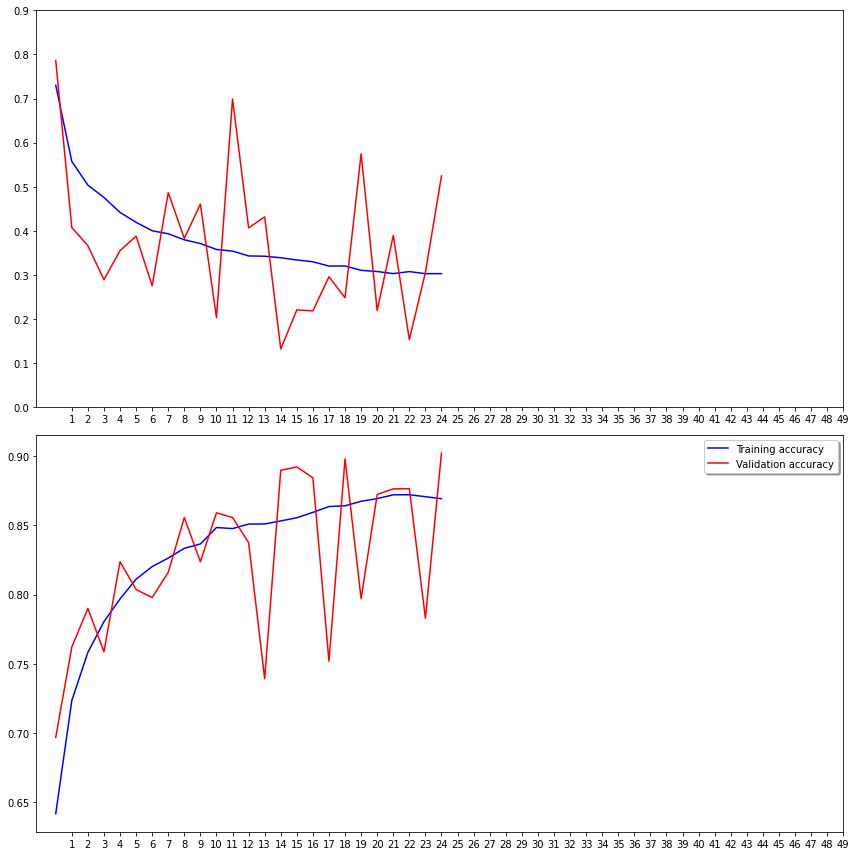

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Chuẩn bị dữ liệu test

In [ ]:
test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

#Tạo Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


#Dự đoán test

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

**Virtaulize Kết quả test**

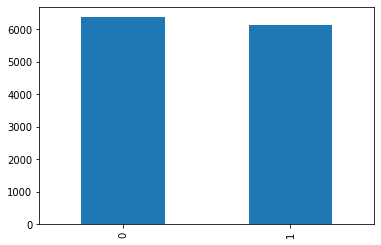

In [ ]:
test_df['category'].value_counts().plot.bar()

**Hiển thị một số kết quả test**

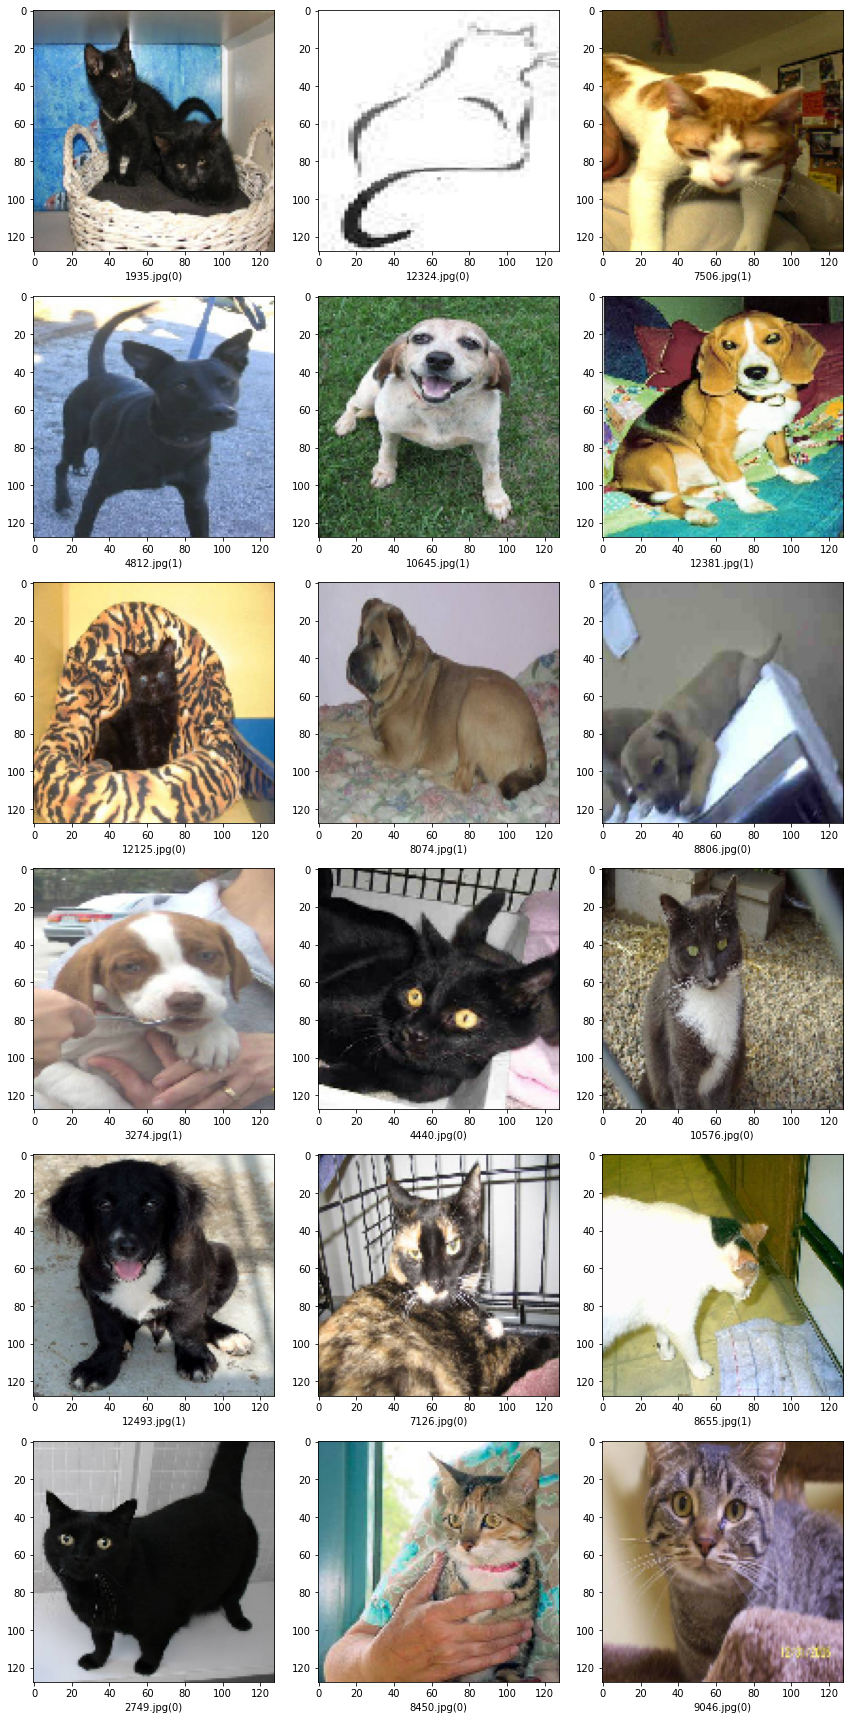

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

### Dự đoán với hình ảnh nhập vào

In [ ]:
test_filenames = os.listdir("/content/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
#tạo testing generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=True
)
#dự đoán
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
test_df['category'] = np.argmax(predict)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
#Chúng ta map data với {1: 'dog', 0: 'cat'}
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

Found 1 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


**Kết quả**

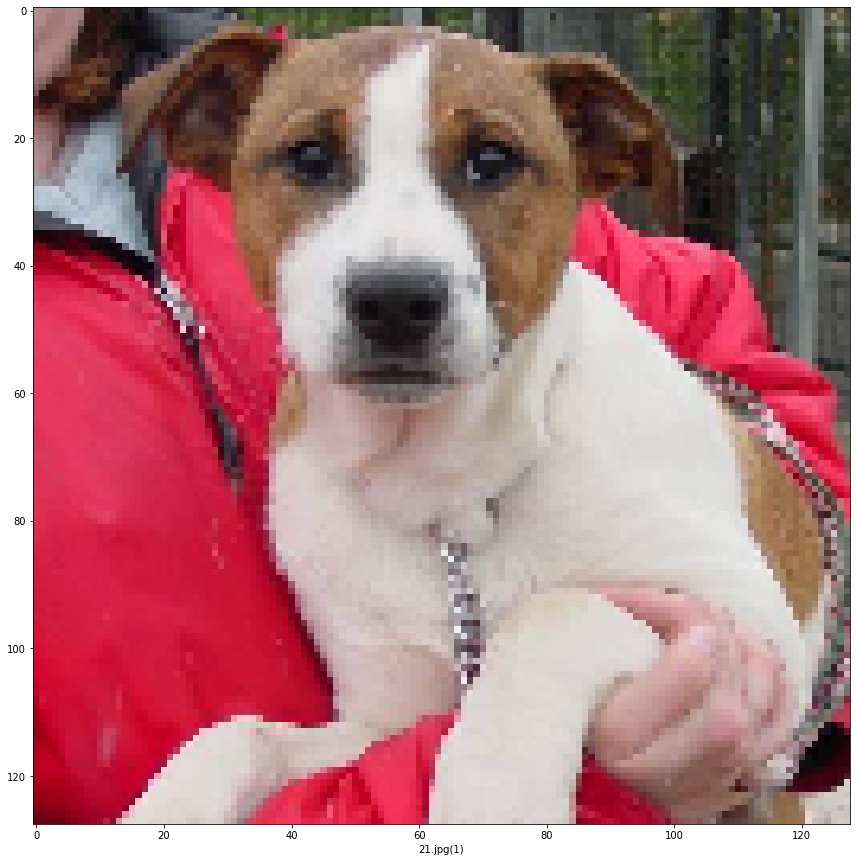

In [ ]:
sample_test = test_df.head(1)
sample_test.head()
plt.figure(figsize=(12,24 ))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(1, 1, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()